# FYND AI ENGINEERING INTERN ASSESSMENT - TASK 1
<hr>

## Rating Prediction via Prompting

`
This notebook implements 3 different prompting approaches to predict
star ratings from Yelp reviews and evaluates their performance.
`

# SECTION 1: Setup

In [1]:
# ============================================================================
# SECTION 1: Setup and Data Loading
# ============================================================================

#!pip install -q -U google-genai

#!pip install pandas numpy time scikit-learn matplotlib


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import json
from typing import Dict, List, Tuple, Optional
from pydantic import BaseModel, Field, field_validator, ValidationError
from google import genai
from collections import defaultdict
import re
from dotenv import load_dotenv
import os

In [40]:
load_dotenv(dotenv_path="../.env")

client = genai.Client()
model = "gemini-2.5-flash"


## SECTION 2: Load, Analyse and Sample Dataset


In [3]:
# Load the Yelp dataset
# Download from: https://www.kaggle.com/datasets/omkarsabnis/yelp-reviews-dataset

df = pd.read_csv("../artifacts/data/yelp.csv")

print(f'Total reviews in dataset: {len(df)}')
print(f"\nColumns: {df.columns.tolist()}")
print(f"\n First few rows:\n")
df.head()


Total reviews in dataset: 10000

Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']

 First few rows:



,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
print(f"Raw Shape: {df.shape}")

df = df[['text', 'stars']].dropna()

df['text'] = df['text'].astype(str)
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')
df = df.dropna(subset = ['stars'])

df = df[df['text'].str.len() > 20].copy()

print(f"Cleaned Shape: {df.shape}")
df.head()

Raw Shape: (10000, 10)
Cleaned Shape: (9953, 2)


,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


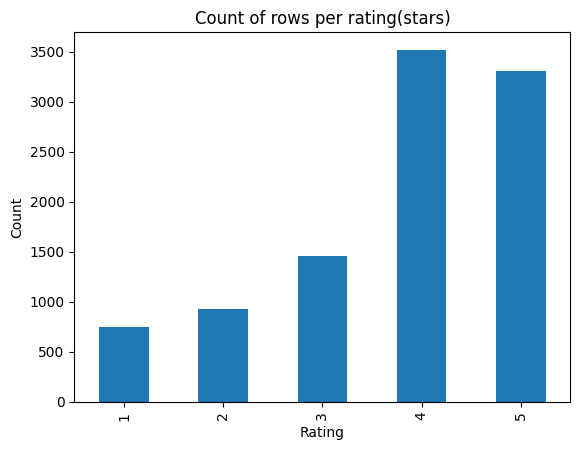

In [5]:
df['stars'].value_counts().sort_index().plot(kind='bar', title="Count of rows per rating(stars)")
plt.xlabel('Rating')
plt.xticks(rotation='vertical')
plt.ylabel('Count')
plt.show()

**Note:** From the above bar plot its quite clear that there is class imbalance but let's visualise it to understand it better


TARGET VARIABLE: Star Ratings

Imbalance ratio: 4.73:1
   (Most common | Least common)


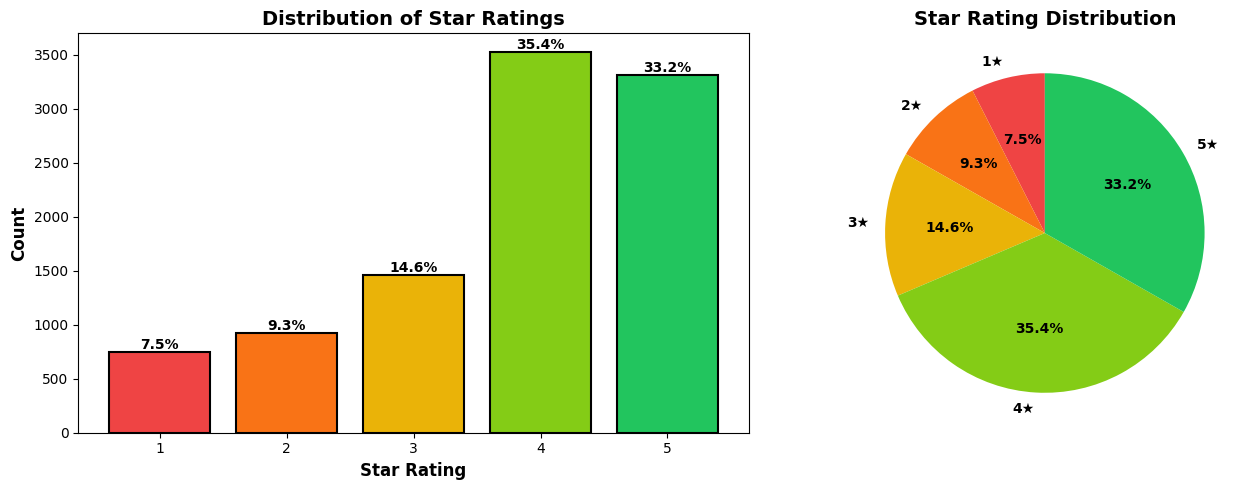

Saved as: fig1_star_distribution.png


In [6]:
y = df['stars'].values  # This is what we want to predict

print("\n" + "="*60)
print("TARGET VARIABLE: Star Ratings")
print("="*60)


unique, counts = np.unique(y, return_counts=True)

# Check for imbalance
max_count = counts.max()
min_count = counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   (Most common | Least common)")



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#ef4444', '#f97316', '#eab308', '#84cc16', '#22c55e']
bars = ax1.bar(unique, counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Star Rating', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Star Ratings', fontsize=14, fontweight='bold')
ax1.set_xticks(unique)
ax1.set_xticklabels([f'{int(s)}' for s in unique])

# Add percentages on bars
for i, (star, count) in enumerate(zip(unique, counts)):
    pct = 100 * count / len(y)
    ax1.text(star, count, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Pie chart
percentages = 100 * counts / len(y)
ax2.pie(counts, labels=[f'{int(s)}★' for s in unique], autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontweight': 'bold'})
ax2.set_title('Star Rating Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./results/fig1_star_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved as: fig1_star_distribution.png")

`Since, I will be using Gemini API later on, I think it would also be beneficial if I can understand the text length in general.`

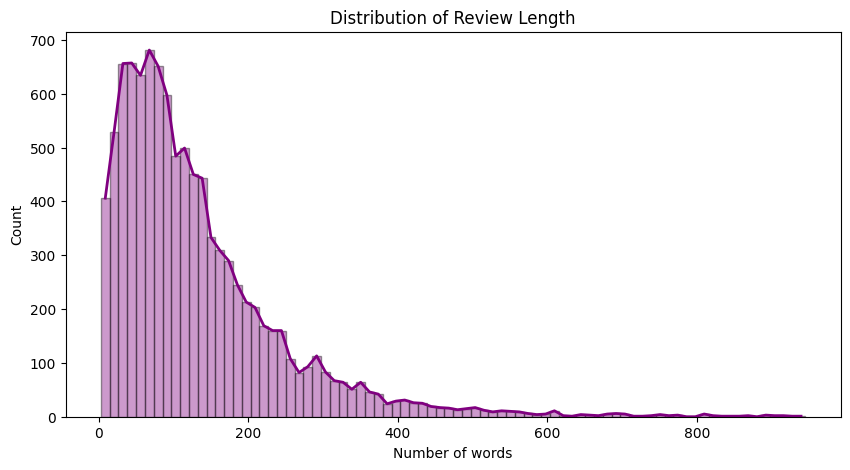

In [7]:
df['length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
counts, bin_edges, patches =  plt.hist(df['length'], bins=80, color="purple", edgecolor='black', alpha=0.4)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_midpoints, counts, color='purple',linestyle='-', linewidth=2, markersize=4)
plt.title('Distribution of Review Length')
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.show()

#### Analysis

Most reviews contain between ~20–150 words, with a long right tail of very long reviews. The distribution is highly skewed, which is typical for user-generated text and suggests that some preprocessing may be needed to handle unusually long reviews.

In [8]:
# Sample 200 reviews stratified by rating(stars)
sample_size = 200
df_sample = df.groupby('stars', group_keys=False).apply(
    lambda x: x.sample(min(len(x), sample_size // 5), random_state=42)
).reset_index(drop=True)

print(f"\n Sampled: {len(df_sample)} reviews")
conmbined_view = df_sample.groupby('stars')['length'].agg(['count', 'mean']).reset_index()
conmbined_view.columns = ['Rating', 'Count', 'Average Length']
print(f"Rating distribution & Avg Length: \n{conmbined_view}")



 Sampled: 200 reviews
Rating distribution & Avg Length: 
   Rating  Count  Average Length
0       1     40         154.525
1       2     40         194.600
2       3     40         127.500
3       4     40         141.400
4       5     40          92.950


/var/folders/q0/_dvcbklj2b7dx718m239hjcr0000gn/T/ipykernel_25147/1494479074.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('stars', group_keys=False).apply(


## SECTION 3: Prompting Approaches + Response Schema

In [ ]:
class ratingPrediction(BaseModel): 
    predicted_stars: int = Field(..., ge=1, le=5, description='Star rating between 1 and 5')
    explanation: str = Field(..., min_length=20, max_length=800, description="Brief reasoning for the rating")

    @field_validator('explanation', mode="before")
    @classmethod
    def strip_explanation(cls, v: str) -> str:
        if isinstance(v, str):
            v = v.strip()
            if not v:
                raise ValueError('Explanation cannot be empty or just whitespace')
        return v

### APPROACH 1: Zero Shot Prompting (Simple & Straightforward)

DESIGN RATIONALE:
- Simple, direct instruction
- Minimal context to test baseline performance
- No examples or reasoning guidance

In [10]:
PROMPT_APPROACH_1 = """You are an assistant that classifies Yelp reviews into 1-5 star ratings.

Your task:
1. Read the review.
2. Decide an integer rating from 1 to 5.
3. Explain your choice briefly.

Review: {review}

Analyze the sentiment and assign an appropriate rating with brief reasoning.
"""

### Approach 2: Rubric Based - providing rating guidelines

DESIGN RATIONALE:
- Provides explicit sentiment indicators for each rating
- Guides the model with concrete examples of what each rating means
- More structured reasoning process
- Should improve accuracy by giving clear classification criteria

In [ ]:
PROMPT_APPROACH_2 = """You are an expert at analyzing customer reviews and predicting ratings(1 - 5).

Rating Guidelines:
- 5 stars: Extremely positive, enthusiastic, words like "amazing", "perfect", "best"
- 4 stars: Positive with minor issues, "good", "nice", "pretty good"
- 3 stars: Mixed/neutral, "okay", "average", "it's fine"
- 2 stars: Mostly negative, "disappointing", "not great", "poor"
- 1 star: Extremely negative, "terrible", "worst", "awful", "never again"

Now, analyse this review:
Review: {review}

Your task:
1. Analyse the review carefully
2. Apply the rubric carefully to the review.
3. Decide an integer rating from 1 to 5.
4. Give a brief reasoning for the assigned rating"""

### APPROACH 3: Chain-of-Thought with Examples (Advanced Reasoning)

DESIGN RATIONALE:
- Uses few-shot learning with concrete examples
- Encourages step-by-step reasoning (chain-of-thought)
- Shows the model exactly what good predictions look like
- Should have highest accuracy due to explicit examples and reasoning

In [ ]:
PROMPT_APPROACH_3 = """You are an expert review analyst. Predict the star rating (1-5) using step-by-step reasoning.

Examples:
Review: "This place is amazing! The food was perfect and service was outstanding."
Reasoning: Extremely positive language ("amazing", "perfect", "outstanding") with no negatives
Rating: 5 stars

Review: "Food was good but service was slow. Would come back."
Reasoning: Positive overall ("good", "would come back") but has a notable issue (slow service)
Rating: 4 stars

Review: "Meh, it's okay. Nothing special but not terrible either."
Reasoning: Neutral language ("meh", "okay", "nothing special"), no strong positive or negative
Rating: 3 stars

Now analyze this review:
Review: {review}

Think step-by-step:
1. Identify positive and negative keywords
2. Assess overall sentiment
3. Consider the balance of opinions
4. Assign appropriate rating with reasoning"""

## Section 4: Prediction Function with Structured Output

In [13]:
def predict_rating(review_text: str, prompt_template: str, approach_name: str) -> Dict:
    """
    Predict rating using given prompt approach with structured output
    
    Using Gemini's response_json_schema for guaranteed JSON format and
    Pydantic for additional validation.
    
    Returns:
        Dict with predicted_stars, explanation, is_valid_json, error (if any)
    """

    try:
        prompt = prompt_template.format(review=review_text)

        response = client.models.generate_content(
            model=model,
            contents=prompt,
            config={
                "response_mime_type": "application/json",
                "response_json_schema": ratingPrediction.model_json_schema()
            }
        )

        output = ratingPrediction.model_validate_json(response.text)

        return {
            "predicted_stars": output.predicted_stars,
            "explanation": output.explanation,
            "is_valid_json": True,
            "error": None
        }
    except ValidationError as e:
        return {
            "predicted_stars": None,
            "explanation": None,
            "is_valid_json": False,
            "error": f"Validation/Parsing failed, Error: {e.errors()}"
        }
    except Exception as e:
        return {
            "predicted_stars": None,
            "explanation": None,
            "is_valid_json": False,
            "error": f"API error: {str(e)}"
        }

## SECTION 5: Batch Evaluation

In [17]:
def evaluate_approach(df: pd.DataFrame, prompt_template: str, approach_name: str) -> pd.DataFrame:
    """
    Evaluating each prompting approach
    """

    print(f"\n{"="*60}")
    print(f"Evaluating {approach_name}")
    print(f"{"="*60}")

    results = []

    for idx, row in df.iterrows():
        if idx > 0 and idx % 15 == 0:
            print(f"    Rate Limiting ... (processed {idx} reviews)")
            time.sleep(60)

        if idx % 20 == 0:
            print(f"    Progress {idx}/{len(df)}")
        
        start = time.time()
        prediction = predict_rating(row['text'], prompt_template, approach_name)
        end = time.time()

        results.append({
            'actual_rating': row['stars'],
            'predicted_rating': prediction['predicted_stars'],
            'explanation': prediction['explanation'],
            "is_valid_json": prediction['is_valid_json'],
            "error": prediction['error'],
            "review_text": row['text'][:100] + '...',
            "latency_sec": end-start,
        })
    
    
    print(f"    Completed {len(results)} preditions")
    return pd.DataFrame(results)

In [18]:
print(f"\n{"="*60}")
print("STARTING EVALUATION OF ALL APPROACHES")
print(f"{"="*60}")

# Evaluate all three approaches
results_approach_1 = evaluate_approach(df_sample, PROMPT_APPROACH_1, "Approach 1: Zero-shot prompting")
results_approach_2 = evaluate_approach(df_sample, PROMPT_APPROACH_2, "Approach 2: Rubric Based")
results_approach_3 = evaluate_approach(df_sample, PROMPT_APPROACH_3, "Approach 3: COT + few-shot")



STARTING EVALUATION OF ALL APPROACHES

Evaluating Approach 1: Zero-shot prompting
    Progress 0/200
    Rate Limiting ... (processed 15 reviews)
    Progress 20/200
    Rate Limiting ... (processed 30 reviews)
    Progress 40/200
    Rate Limiting ... (processed 45 reviews)
    Rate Limiting ... (processed 60 reviews)
    Progress 60/200
    Rate Limiting ... (processed 75 reviews)
    Progress 80/200
    Rate Limiting ... (processed 90 reviews)
    Progress 100/200
    Rate Limiting ... (processed 105 reviews)
    Rate Limiting ... (processed 120 reviews)
    Progress 120/200
    Rate Limiting ... (processed 135 reviews)
    Progress 140/200
    Rate Limiting ... (processed 150 reviews)
    Progress 160/200
    Rate Limiting ... (processed 165 reviews)
    Rate Limiting ... (processed 180 reviews)
    Progress 180/200
    Rate Limiting ... (processed 195 reviews)
    Completed 200 preditions

Evaluating Approach 2: Rubric Based
    Progress 0/200
    Rate Limiting ... (processed 15 

## SECTION 6: Calculate Metrics

In [19]:
def calculate_metrics(results_df: pd.DataFrame) -> Dict:
    """
    Calculates the accuracy and json validity
    """
    valid_predictions = results_df[results_df['is_valid_json']]
    json_validity = len(valid_predictions)/len(results_df) * 100

    avg_latency = results_df["latency_sec"].mean()

    if(len(valid_predictions) == 0):
        return {
            'json_validity_rate': json_validity,
            'accuracy': 0,
            'exact_match_accuracy': 0,
            'off_by_one_accuracy': 0,
            'mean_absolute_error': None,
            'avg_latency': avg_latency
        }
    
    exact_matches = (valid_predictions['actual_rating'] == valid_predictions['predicted_rating']).sum()
    accuracy = exact_matches / len(valid_predictions) * 100

    off_by_one = (abs(valid_predictions['actual_rating'] - valid_predictions['predicted_rating']) <= 1).sum()
    off_by_one_accuracy = off_by_one / len(valid_predictions) * 100

    mae = abs(valid_predictions['actual_rating'] - valid_predictions['predicted_rating']).mean()

    return {
        'json_validity_rate': json_validity,
        'accuracy': accuracy,
        'exact_match_accuracy': accuracy,
        'off_by_one_accuracy': off_by_one_accuracy,
        'mean_absolute_error': mae,
        'avg_latency': avg_latency,
        'total_predictions': len(results_df),
        'valid_predictions': len(valid_predictions)
    }

In [20]:
metrics_1 = calculate_metrics(results_approach_1)
metrics_2 = calculate_metrics(results_approach_2)
metrics_3 = calculate_metrics(results_approach_3)

## SECTION 7: Comparison Table

In [22]:
print(f"\n{"="*60}")
print("EVALUATION RESULTS - COMPARISON TABLE")
print(f"\n{"="*60}")

comparison_df = pd.DataFrame({
    'Approach': [
        'Approach 1: Direct',
        'Approach 2: Rubric Based',
        'Approach 3: Chain-of-Thought'
    ],
    'JSON Validity (%)': [
        f"{metrics_1['json_validity_rate']:.1f}",
        f"{metrics_2['json_validity_rate']:.1f}",
        f"{metrics_3['json_validity_rate']:.1f}"
    ],
    'Exact Accuracy (%)': [
        f"{metrics_1['accuracy']:.1f}",
        f"{metrics_2['accuracy']:.1f}",
        f"{metrics_3['accuracy']:.1f}"
    ],
    'Avg_Latency (sec)': [
        f"{metrics_1['avg_latency']:.4f}",
        f"{metrics_2['avg_latency']:.4f}",
        f"{metrics_3['avg_latency']:.4f}"
    ],
    'Off-by-1 Accuracy (%)': [
        f"{metrics_1['off_by_one_accuracy']:.1f}",
        f"{metrics_2['off_by_one_accuracy']:.1f}",
        f"{metrics_3['off_by_one_accuracy']:.1f}"
    ],
    'Mean Absolute Error': [
        f"{metrics_1['mean_absolute_error']:.2f}" if metrics_1['mean_absolute_error'] else "N/A",
        f"{metrics_2['mean_absolute_error']:.2f}" if metrics_2['mean_absolute_error'] else "N/A",
        f"{metrics_3['mean_absolute_error']:.2f}" if metrics_3['mean_absolute_error'] else "N/A"
    ]
})

print(comparison_df.to_string(index=False))


EVALUATION RESULTS - COMPARISON TABLE

                    Approach JSON Validity (%) Exact Accuracy (%) Avg_Latency (sec) Off-by-1 Accuracy (%) Mean Absolute Error
          Approach 1: Direct              97.5               60.0            3.3539                  97.4                0.43
    Approach 2: Rubric Based              88.5               63.3            4.5209                  98.3                0.38
Approach 3: Chain-of-Thought              55.0               64.5            4.6556                  98.2                0.37


## SECTION 8: Error Analysis

In [23]:
print(f"\n{"="*60}")
print("ERROR ANALYSIS")
print(f"\n{"="*60}")

for name, results in [
    ("Approach 1", results_approach_1),
    ("Approach 2", results_approach_2),
    ("Approach 3", results_approach_3)
]:
    errors = results[results['is_valid_json'] == False]
    print(f"\n{name}:")
    print(f"  Total Errors: {len(errors)}")
    if len(errors) > 0:
        print(f"  Error Types:")
        print(errors['error'].value_counts())


ERROR ANALYSIS


Approach 1:
  Total Errors: 5
  Error Types:
error
API error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}    5
Name: count, dtype: int64

Approach 2:
  Total Errors: 23
  Error Types:
error
Validation/Parsing failed, Error: [{'type': 'string_too_long', 'loc': ('explanation',), 'msg': 'String should have at most 400 characters', 'input': 'The customer experienced severe damage to their natural nails due to improper gel removal, resulting in them becoming extremely thin and flimsy. The new polish application was also uneven. Furthermore, the customer service was unhelpful and dismissive, refusing a refund and denying the issue. The review uses strong negative language like "Horrible!" and "never go back," indicating extreme dissatisfaction and a terrible experience.', 'ctx': {'max_length': 400}, 'url': 'https://errors.pydantic.dev/2.12/v/string_too_long'}]                              

So, from this 

## SECTION 9: Confusion Matrix

In [28]:
def display_confusion_matrix(results_df: pd.DataFrame, approach_name:str):
    print(f"\n{"="*60}")
    print(f"CONFUSION MATRIX - {approach_name}")
    print(f"\n{"="*60}")

    valid_results = results_df[results_df['is_valid_json'] == True]
    confusion_matrix = pd.crosstab(
        valid_results['actual_rating'], 
        valid_results['predicted_rating'],
        rownames=['Actual'],
        colnames=['Predicted']
    )

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


CONFUSION MATRIX - Approach 1: Zero-shot prompting



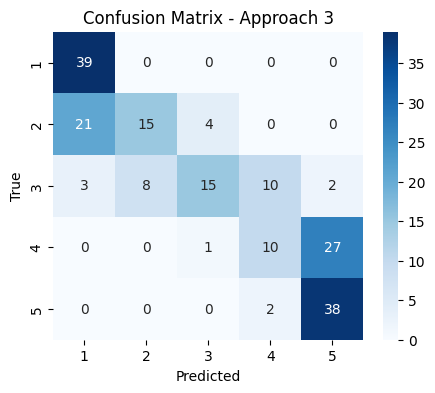

In [29]:
display_confusion_matrix(results_approach_1, "Approach 1: Zero-shot prompting")


CONFUSION MATRIX - Approach 2: Rubric Based



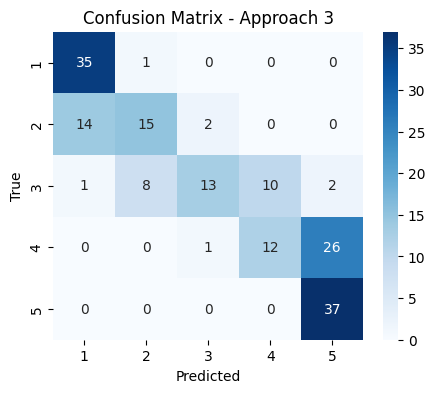

In [30]:
display_confusion_matrix(results_approach_2, "Approach 2: Rubric Based")


CONFUSION MATRIX - Approach 3: COT + few-shot



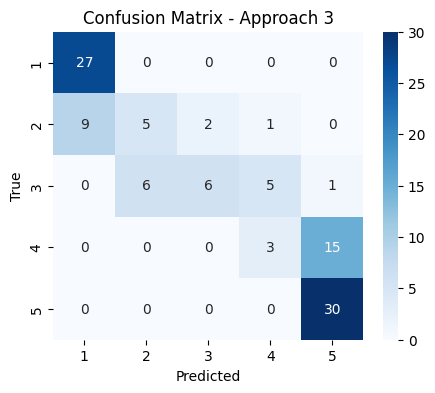

In [32]:
display_confusion_matrix(results_approach_3, "Approach 3: COT + few-shot")

## SECTION 10: Save Results

In [39]:
# Save all results to CSV
results_approach_1.to_csv('./results/approach_1_results.csv', index=False)
results_approach_2.to_csv('./results/approach_2_results.csv', index=False)
results_approach_3.to_csv('./results/approach_3_results.csv', index=False)

# Save comparison table
comparison_df.to_csv('./results/comparison_results.csv', index=False)